In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [3]:
import torch.optim as optim
from torch.utils import data

In [4]:
import nflib
from nflib.flows import SequentialFlow, ActNorm, ActNorm2D, BatchNorm1DFlow, BatchNorm2DFlow
import nflib.coupling_flows as icf
import nflib.res_flow as irf

In [5]:
seed = 123

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

### Datasets

In [6]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="./data/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="./data/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# cifar_train = transforms.Compose([
#     transforms.RandomCrop(size=32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.5071, 0.4865, 0.4409],
#         std=[0.2009, 0.1984, 0.2023],
#     ),
# ])

# cifar_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.5071, 0.4865, 0.4409],
#         std=[0.2009, 0.1984, 0.2023],
#     ),
# ])

# train_dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=cifar_train)
# test_dataset = datasets.CIFAR100(root="./data", train=False, download=True, transform=cifar_test)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=4)

In [9]:
for xx, yy in train_loader:
    break

In [10]:
xx.shape

torch.Size([128, 3, 32, 32])

### Model

In [11]:
actf = irf.Swish
# Norm1D = BatchNorm1DFlow
# Norm2D = BatchNorm2DFlow
Norm1D = ActNorm
Norm2D = ActNorm2D
flows = [
    Norm2D(3),
    irf.ConvResidualFlow([3, 32, 32], [32, 32], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
    Norm2D(12),
    irf.ConvResidualFlow([12, 16, 16], [64, 64], kernels=5, activation=actf),
    Norm2D(12),
    irf.ConvResidualFlow([12, 16, 16], [64, 64], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
    Norm2D(48),
    irf.ConvResidualFlow([48, 8, 8], [128, 128], kernels=5, activation=actf),
    Norm2D(48),
    irf.ConvResidualFlow([48, 8, 8], [128, 128], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
    Norm2D(192),
    irf.ConvResidualFlow([192, 4, 4], [256, 256], kernels=5, activation=actf),
    Norm2D(192),
    irf.ConvResidualFlow([192, 4, 4], [256, 256], kernels=5, activation=actf),
    Norm2D(192),
    irf.Flatten(img_size=[192, 4, 4]),
    Norm1D(3072),
#     nn.Linear(3072, 2),
#     Norm1D(2),
        ]

# backbone = SequentialFlow(flows)
backbone = nn.Sequential(*flows)

In [12]:
backbone.to(device)

Sequential(
  (0): ActNorm2D()
  (1): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Swish()
      (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Swish()
      (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (2): InvertiblePooling()
  (3): ActNorm2D()
  (4): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Swish()
      (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Swish()
      (4): Conv2d(64, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (5): ActNorm2D()
  (6): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Swish()
      (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Swish

In [13]:
backbone(xx.to(device)).shape, 32*32*3

(torch.Size([128, 3072]), 3072)

In [14]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

def remove_spectral_norm(model):
    for child in get_children(model):
        if hasattr(child, 'weight'):
            print("Yes", child)
            try:
                irf.remove_spectral_norm_conv(child)
                print("Success : irf conv")
            except Exception as e:
#                     print(e)
                print("Failed : irf conv")

            try:
                irf.remove_spectral_norm(child)
                print("Success : irf lin")
            except Exception as e:
#                     print(e)
                print("Failed : irf lin")

            try:
                nn.utils.remove_spectral_norm(child)
                print("Success : nn")
            except Exception as e:
#                     print(e)
                print("Failed : nn")
    return

In [15]:
# remove_spectral_norm(backbone)

In [16]:
print("number of params: ", sum(p.numel() for p in backbone.parameters()))

number of params:  9947519


In [17]:
for xx, yy in train_loader:
    tt = backbone(xx.to(device))
    print(xx.shape, tt.shape)
    break

torch.Size([128, 3, 32, 32]) torch.Size([128, 3072])


In [18]:
class ConnectedClassifier_Linear(nn.Module):

    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)

        self.linear = nn.Linear(input_dim, num_sets)

        init_val = torch.randn(num_sets, output_dim)
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 5
        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None


    def forward(self, x, hard=False):
        x = self.linear(x)*torch.exp(self.inv_temp)
        if hard:
            x = torch.softmax(x*1e5, dim=1)
        else:
            x = torch.softmax(x, dim=1)
#             x = torch.softmax(x*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [19]:
class ConnectedClassifier_Distance(nn.Module):

    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)

        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        self.bias = nn.Parameter(torch.zeros(1, num_sets))
#         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)

        init_val = torch.randn(num_sets, output_dim)
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 5
        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None


    def forward(self, x, hard=False):

        dists = torch.cdist(x, self.centers)
        ### correction to make diagonal of unit square 1 in nD space
        dists = dists/np.sqrt(self.input_dim) + self.bias
        dists = dists*torch.exp(self.inv_temp)
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists, dim=1)
#             x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [20]:
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [21]:
train_loader.dataset.transforms

StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [22]:
#### C10
classifier = ConnectedClassifier_Distance(3072, 100, 10, inv_temp=3.)
#### for MLP based classification
# classifier = nn.Sequential(nn.Linear(3072, 100), nn.SELU(), nn.Linear(100, 10))

classifier = classifier.to(device)

In [23]:
# classifier.set_centroid_to_data_randomly(train_loader, backbone)

In [24]:
print("number of params: ", sum(p.numel() for p in backbone.parameters()))
print("number of params: ", sum(p.numel() for p in classifier.parameters()))

number of params:  9947519
number of params:  308301


In [25]:
model = nn.Sequential(backbone, classifier).to(device)

In [26]:
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  10255820


## Training

In [27]:
model_name = 'c10_actnorm_multi_invex'
# model_name = 'c10_batchnorm_multi_invex'

In [28]:
EPOCHS = 200
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [29]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [30]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

In [31]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [32]:
# ### Train the whole damn thing

# for epoch in range(start_epoch, start_epoch+EPOCHS):
#     train(epoch)
#     test(epoch)
#     scheduler.step()

In [33]:
best_acc

-1

In [34]:
classifier.inv_temp

Parameter containing:
tensor([3.], device='cuda:0', requires_grad=True)

In [35]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(84.07, 185)

In [36]:
for k in model.state_dict().keys():
    print(k)

0.0.s
0.0.t
0.1.resblock.0.bias
0.1.resblock.0.weight_orig
0.1.resblock.0.weight_u
0.1.resblock.0.weight_v
0.1.resblock.0.weight_sigma
0.1.resblock.1.beta
0.1.resblock.2.bias
0.1.resblock.2.weight_orig
0.1.resblock.2.weight_u
0.1.resblock.2.weight_v
0.1.resblock.2.weight_sigma
0.1.resblock.3.beta
0.1.resblock.4.bias
0.1.resblock.4.weight_orig
0.1.resblock.4.weight_u
0.1.resblock.4.weight_v
0.1.resblock.4.weight_sigma
0.3.s
0.3.t
0.4.resblock.0.bias
0.4.resblock.0.weight_orig
0.4.resblock.0.weight_u
0.4.resblock.0.weight_v
0.4.resblock.0.weight_sigma
0.4.resblock.1.beta
0.4.resblock.2.bias
0.4.resblock.2.weight_orig
0.4.resblock.2.weight_u
0.4.resblock.2.weight_v
0.4.resblock.2.weight_sigma
0.4.resblock.3.beta
0.4.resblock.4.bias
0.4.resblock.4.weight_orig
0.4.resblock.4.weight_u
0.4.resblock.4.weight_v
0.4.resblock.4.weight_sigma
0.5.s
0.5.t
0.6.resblock.0.bias
0.6.resblock.0.weight_orig
0.6.resblock.0.weight_u
0.6.resblock.0.weight_v
0.6.resblock.0.weight_sigma
0.6.resblock.1.beta
0.6

In [37]:
for k in checkpoint["model"].keys():
    print(k)

0.0.s
0.0.t
0.1.resblock.0.bias
0.1.resblock.0.weight_orig
0.1.resblock.0.weight_u
0.1.resblock.0.weight_v
0.1.resblock.0.weight_sigma
0.1.resblock.1.beta
0.1.resblock.2.bias
0.1.resblock.2.weight_orig
0.1.resblock.2.weight_u
0.1.resblock.2.weight_v
0.1.resblock.2.weight_sigma
0.1.resblock.3.beta
0.1.resblock.4.bias
0.1.resblock.4.weight_orig
0.1.resblock.4.weight_u
0.1.resblock.4.weight_v
0.1.resblock.4.weight_sigma
0.3.s
0.3.t
0.4.resblock.0.bias
0.4.resblock.0.weight_orig
0.4.resblock.0.weight_u
0.4.resblock.0.weight_v
0.4.resblock.0.weight_sigma
0.4.resblock.1.beta
0.4.resblock.2.bias
0.4.resblock.2.weight_orig
0.4.resblock.2.weight_u
0.4.resblock.2.weight_v
0.4.resblock.2.weight_sigma
0.4.resblock.3.beta
0.4.resblock.4.bias
0.4.resblock.4.weight_orig
0.4.resblock.4.weight_u
0.4.resblock.4.weight_v
0.4.resblock.4.weight_sigma
0.5.s
0.5.t
0.6.resblock.0.bias
0.6.resblock.0.weight_orig
0.6.resblock.0.weight_u
0.6.resblock.0.weight_v
0.6.resblock.0.weight_sigma
0.6.resblock.1.beta
0.6

In [38]:
checkpoint.keys()

dict_keys(['model', 'acc', 'epoch'])

In [39]:
model_name

'c10_actnorm_multi_invex'

In [40]:
asdasd

NameError: name 'asdasd' is not defined

In [41]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

### Hard test accuracy with count per classifier

In [42]:
model.eval()
print("Testing")

Testing


In [43]:
backbone, classifier = model[0], model[1]

In [44]:
classifier

ConnectedClassifier_Distance()

In [45]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
model.eval()
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

acc = float(test_acc)/test_count*100
print(f'Hard Acc:{acc:.2f}%')

100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.66it/s]

Hard Acc:84.05%


In [46]:
## Everything great... collect the images and labes for each cluster

In [47]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
set_acc = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        
    cls_indx = torch.argmax(classifier.cls_confidence, dim=1)
    set_indx, count = torch.unique(cls_indx, return_counts=True) 
    set_count[set_indx] += count
    
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float)
    
    ### class_index has 100 possible values
    for i, c in enumerate(correct):
        set_acc[cls_indx[i]] += c
    
#     print(set_acc.sum(), set_count.sum())
#     break
    test_acc += correct.sum()
    test_count += len(xx)

print(f'Hard Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.14it/s]

Hard Acc:84.05%
[0, 0, 138, 0, 0, 0, 0, 742, 0, 0, 0, 0, 0, 1026, 0, 1, 1010, 0, 0, 0, 1014, 0, 0, 0, 0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 0, 1013, 0, 0, 0, 774, 0, 0, 0, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1012, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 710, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1004, 0, 0, 0, 0, 163, 0, 0, 105, 0, 0, 0, 0, 228, 0, 0]


In [48]:
print(f"idx,\tcls,\tacc \ttot,\tpercent%")
for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    print(f"{i},\t{cls},\t{int(acc*cnt)}\t{cnt},\t{acc*100:.2f}%")

idx,	cls,	acc 	tot,	percent%
2,	2,	112	138,	81.88%
7,	7,	679	742,	91.64%
13,	3,	707	1026,	69.01%
15,	5,	1	1,	100.00%
16,	6,	886	1010,	87.72%
20,	0,	863	1014,	85.21%
29,	9,	45	52,	86.54%
35,	5,	756	1013,	74.63%
39,	9,	703	774,	90.83%
48,	8,	909	999,	91.09%
61,	1,	918	1012,	90.81%
68,	8,	4	7,	57.14%
72,	2,	577	710,	81.27%
83,	3,	1	2,	50.00%
84,	4,	830	1004,	82.67%
89,	9,	143	163,	87.73%
92,	2,	80	105,	76.19%
97,	7,	185	228,	81.14%


In [50]:
len(set_count.nonzero())

18

## collect data points for all sets

In [51]:
idx_data_dict = {}

for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    idx_data_dict[i] = {"cls":cls, "correct":int(acc*cnt), "total":cnt, "acc":acc*100, "xs":[], "ys":[]}
    
idx_data_dict

{2: {'cls': 2,
  'correct': 112,
  'total': 138,
  'acc': 81.88405632972717,
  'xs': [],
  'ys': []},
 7: {'cls': 7,
  'correct': 679,
  'total': 742,
  'acc': 91.64420366287231,
  'xs': [],
  'ys': []},
 13: {'cls': 3,
  'correct': 707,
  'total': 1026,
  'acc': 69.00584697723389,
  'xs': [],
  'ys': []},
 15: {'cls': 5, 'correct': 1, 'total': 1, 'acc': 100.0, 'xs': [], 'ys': []},
 16: {'cls': 6,
  'correct': 886,
  'total': 1010,
  'acc': 87.72277235984802,
  'xs': [],
  'ys': []},
 20: {'cls': 0,
  'correct': 863,
  'total': 1014,
  'acc': 85.20709872245789,
  'xs': [],
  'ys': []},
 29: {'cls': 9,
  'correct': 45,
  'total': 52,
  'acc': 86.53846383094788,
  'xs': [],
  'ys': []},
 35: {'cls': 5,
  'correct': 756,
  'total': 1013,
  'acc': 74.62981343269348,
  'xs': [],
  'ys': []},
 39: {'cls': 9,
  'correct': 703,
  'total': 774,
  'acc': 90.82687497138977,
  'xs': [],
  'ys': []},
 48: {'cls': 8,
  'correct': 909,
  'total': 999,
  'acc': 91.09109044075012,
  'xs': [],
  'ys': [

In [52]:
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        
    cls_indx = torch.argmax(classifier.cls_confidence, dim=1).cpu().numpy()
    
    for i in range(len(cls_indx)):
        regi = cls_indx[i]
        x = xx[i].cpu()
        y = yy[i].cpu()
        
        idx_data_dict[regi]["xs"].append(x)
        idx_data_dict[regi]["ys"].append(y)
    pass

100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.24it/s]


In [53]:
# for key, val in idx_data_dict.items():
#     print(key)
#     xs = torch.cat(val['xs'], dim=0).to(device)
#     ys = torch.LongTensor(val['ys'])
    
#     del xs

In [54]:
classifier.centers.shape

torch.Size([100, 3072])

In [55]:
invbackbone = SequentialFlow([*backbone])
invbackbone

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm2D()
    (1): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): Swish()
        (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): Swish()
        (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
    )
    (2): InvertiblePooling()
    (3): ActNorm2D()
    (4): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): Swish()
        (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): Swish()
        (4): Conv2d(64, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
    )
    (5): ActNorm2D()
    (6): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): Swish()
        (2): C

In [56]:
classifier.input_dim

3072

In [57]:
classifier.centers.data.shape

torch.Size([100, 3072])

In [58]:
with torch.no_grad():
    xcenter = invbackbone.inverse(classifier.centers.data)

In [59]:
xcenter.shape

torch.Size([100, 3, 32, 32])

In [60]:
i=0

In [61]:
# dmean, dstd = np.array([0, 0, 0]) , np.array([1, 1, 1]) ##f/mnist
dmean, dstd = np.array([0.4914, 0.4822, 0.4465]) , np.array([0.2023, 0.1994, 0.2010])
# dmean, dstd = np.array([0.5071, 0.4865, 0.4409]) , np.array([0.2009, 0.1984, 0.2023]) ##cifar100

0


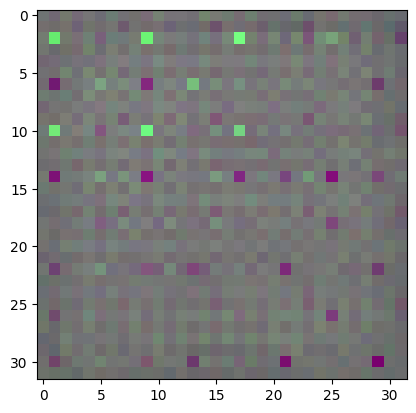

In [62]:
#### Run this cell to visualize centers iteratively.... ||||||||||||||||||||
img = xcenter[i].cpu().permute(1,2,0).numpy()*dstd + dmean
img = (img - img.min()) / (img.max()- img.min())
plt.imshow(img)
print(i)
i+=1

#### test reversibility of the network

In [63]:
for xx, yy in test_loader:
    break

In [64]:
# i = 0

In [65]:
# ximg = xx[i].cpu().permute(1,2,0).numpy()*dstd + dmean
# i+=1
# plt.imshow(ximg)

In [66]:
xx = xx.to(device)

In [67]:
backbone(xx).data.shape

torch.Size([128, 3072])

In [68]:
with torch.no_grad():
    xx_ = invbackbone.inverse(invbackbone(xx).data)

In [69]:
i = 0

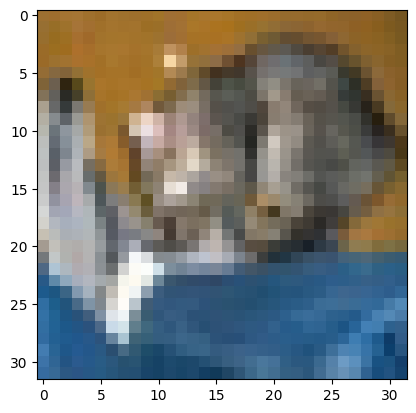

Reconstruction


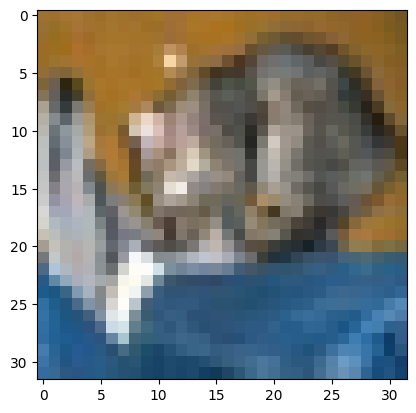

True
0


In [70]:
ximg_ = xx_[i].cpu().permute(1,2,0).numpy()*dstd + dmean
plt.imshow(ximg_)
plt.show()
print("Reconstruction")
ximg = xx[i].cpu().permute(1,2,0).numpy()*dstd + dmean
plt.imshow(ximg)
plt.show()
print("True")
print(i)
i+=1

In [71]:
ximg_.max(), ximg_.min()

(0.9999921234607696, 0.050970848679542546)

In [72]:
classifier.centers.max()

tensor(2.3499, device='cuda:0', grad_fn=<MaxBackward1>)

## Now plot all centers as per index

In [73]:
with torch.no_grad():
    xcenter = invbackbone.inverse(classifier.centers.data)

In [74]:
os.makedirs(f"./invex_out/multiinvex_centers_viz/{model_name}", exist_ok=True)

In [75]:
imgsize = [3,32,32]
# imgsize = [1,28,28]
    
if isinstance(train_dataset, datasets.FashionMNIST):
    train_dataset.classes[0] = 'T-shirt'

In [76]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [77]:
with torch.no_grad():
    for key, val in idx_data_dict.items():
        print(key, val['total'])
        xs = torch.stack(val['xs'], dim=0).to(device)

#         print(xs.shape)
        zs = backbone(xs)

        ### find the medoid in z-space
        idx = torch.cdist(zs, zs).sum(dim=0).argmin()
        img = xs[idx].cpu().view(*imgsize).permute(1,2,0).numpy()*dstd + dmean
        img = (img - img.min()) / (img.max()- img.min())
        plt.imshow(img)
        plt.axis('off')
        plt.savefig(f"./invex_out/multiinvex_centers_viz/{model_name}/zmedoid_({key})_{train_dataset.classes[val['cls']]}.png", bbox_inches='tight')
        plt.close()
        
        ### find nearest in z-space
        idx = torch.norm(zs-classifier.centers[key].view(1, np.prod(imgsize)), dim=1).argmin()
        img = xs[idx].cpu().view(*imgsize).permute(1,2,0).numpy()*dstd + dmean
        img = (img - img.min()) / (img.max()- img.min())
        plt.imshow(img)
        plt.axis('off')
        plt.savefig(f"./invex_out/multiinvex_centers_viz/{model_name}/znearest_({key})_{train_dataset.classes[val['cls']]}.png", bbox_inches='tight')
        plt.close()


        ### find the medoid in x-space
        xs = xs.view(-1, np.prod(imgsize))

        ys = torch.LongTensor(val['ys'])

        ## save center
        img = xcenter[key].cpu().permute(1,2,0).numpy()*dstd + dmean
        img = (img - img.min()) / (img.max()- img.min())
        plt.imshow(img)
        plt.axis('off')
        plt.savefig(f"./invex_out/multiinvex_centers_viz/{model_name}/xcenter_({key})_{train_dataset.classes[val['cls']]}.png", bbox_inches='tight')
        plt.close()

        ## find medoid of the data
        print("xMedoid", idx:=torch.cdist(xs, xs).sum(dim=0).argmin())

        img = xs[idx].cpu().view(*imgsize).permute(1,2,0).numpy()*dstd + dmean
        img = (img - img.min()) / (img.max()- img.min())
        plt.imshow(img)
        plt.axis('off')
        plt.savefig(f"./invex_out/multiinvex_centers_viz/{model_name}/xmedoid_({key})_{train_dataset.classes[val['cls']]}.png", bbox_inches='tight')
        plt.close()

        ## find closest data point
        print("xNearest", idx:=torch.norm(xs-xcenter[key].view(1, np.prod(imgsize)), dim=1).argmin())

        img = xs[idx].cpu().view(*imgsize).permute(1,2,0).numpy()*dstd + dmean
        img = (img - img.min()) / (img.max()- img.min())
        plt.imshow(img)
        plt.axis('off')
        plt.savefig(f"./invex_out/multiinvex_centers_viz/{model_name}/xnearest_({key})_{train_dataset.classes[val['cls']]}.png", bbox_inches='tight')
        plt.close()

        del xs, ys

2 138
xMedoid tensor(135, device='cuda:0')
xNearest tensor(69, device='cuda:0')
7 742
xMedoid tensor(455, device='cuda:0')
xNearest tensor(455, device='cuda:0')
13 1026
xMedoid tensor(1015, device='cuda:0')
xNearest tensor(967, device='cuda:0')
15 1
xMedoid tensor(0, device='cuda:0')
xNearest tensor(0, device='cuda:0')
16 1010
xMedoid tensor(481, device='cuda:0')
xNearest tensor(617, device='cuda:0')
20 1014
xMedoid tensor(83, device='cuda:0')
xNearest tensor(837, device='cuda:0')
29 52
xMedoid tensor(13, device='cuda:0')
xNearest tensor(18, device='cuda:0')
35 1013
xMedoid tensor(981, device='cuda:0')
xNearest tensor(667, device='cuda:0')
39 774
xMedoid tensor(13, device='cuda:0')
xNearest tensor(666, device='cuda:0')
48 999
xMedoid tensor(364, device='cuda:0')
xNearest tensor(9, device='cuda:0')
61 1012
xMedoid tensor(921, device='cuda:0')
xNearest tensor(957, device='cuda:0')
68 7
xMedoid tensor(3, device='cuda:0')
xNearest tensor(3, device='cuda:0')
72 710
xMedoid tensor(492, devic

### Verify Reversibility

In [78]:
for xx, yy in train_loader:
    break

In [79]:
invback = SequentialFlow(backbone).to(device)
# invback.train()
invback.eval()

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm2D()
    (1): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): Swish()
        (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): Swish()
        (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
    )
    (2): InvertiblePooling()
    (3): ActNorm2D()
    (4): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): Swish()
        (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): Swish()
        (4): Conv2d(64, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
    )
    (5): ActNorm2D()
    (6): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): Swish()
        (2): C

In [80]:
torch.cuda.empty_cache()

In [81]:
with torch.no_grad():
    yys_ = invback.forward_intermediate(xx.to(device))
    xxs_ = invback.inverse_intermediate(yys_[-1].to(device))

In [82]:
len(invback.flows), len(xxs_), len(yys_)

(20, 21, 21)

In [83]:
for i in range(len(invback.flows)):
    print(invback.flows[-i-1])
    print("f", yys_[-i-1].min(), yys_[-i-1].max(), yys_[-i-1].mean(), yys_[-i-1].std())
    print("r", xxs_[i+1].min(), xxs_[i+1].max())
    print()

ActNorm()
f tensor(-276.7374) tensor(347.9033) tensor(0.1002) tensor(5.4070)
r tensor(-53.4207) tensor(77.4653)

Flatten()
f tensor(-53.4207) tensor(77.4653) tensor(0.1254) tensor(3.1592)
r tensor(-53.4207) tensor(77.4653)

ActNorm2D()
f tensor(-53.4207) tensor(77.4653) tensor(0.1254) tensor(3.1592)
r tensor(-120.2801) tensor(99.9582)

ConvResidualFlow(
  (resblock): ModuleList(
    (0): Conv2d(192, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Swish()
    (2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): Swish()
    (4): Conv2d(256, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)
f tensor(-120.2801) tensor(99.9582) tensor(0.1791) tensor(5.6086)
r tensor(-120.6320) tensor(100.5804)

ActNorm2D()
f tensor(-120.6320) tensor(100.5804) tensor(0.1745) tensor(5.6358)
r tensor(-100.3483) tensor(59.9762)

ConvResidualFlow(
  (resblock): ModuleList(
    (0): Conv2d(192, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1

In [84]:
invback.flows[2].training

False

In [85]:
xxs_[0].min(), xxs_[0].max()

(tensor(-276.7374), tensor(347.9033))

In [86]:
yys_[-1].min(), yys_[-1].max()

(tensor(-276.7374), tensor(347.9033))